In [ ]:
pip install openpyxl

In [ ]:
pip install GoogleNews spacy==2.2.3

In [ ]:
!python -m spacy download pt_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 41.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
from GoogleNews import GoogleNews
import pandas as pd
from datetime import date
import spacy
import re
from transformers import pipeline
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
nlp = spacy.load("pt_core_news_sm")

In [ ]:

def get_news(news_word:str, lang:str, start_date:date, end_date:date, last_page:int):

  """
  Função para obter as notícias do Google News

  Parâmetros:
  news_word (str): Palavra-chave para a pesquisa no Google News
  start_date (date): Data de início da pesquisa no Google News
  end_date (date): Data de término da pesquisa no Google News
  last_page (int): Número de páginas da pesquisa no Google News
  lang (str): Idioma do Google News
  """

  list_news = []
  google_news = GoogleNews(start=start_date, end=end_date)
  google_news.set_lang(lang)
  google_news.set_encode('utf-8')
  google_news.search(news_word)

  pages = range(1,last_page+1)
  for page in pages:
    google_news.get_page(page)
    list_news.extend(google_news.results())
    news_dataframe = pd.DataFrame(list_news)

  news_dataframe_unique = news_dataframe.drop_duplicates(subset='title')
  news_dataframe_unique['title'] = news_dataframe_unique['title'].apply(lambda x: x.encode('utf-8').decode('utf-8', 'ignore'))
  news_dataframe_unique['desc'] = news_dataframe_unique['desc'].apply(lambda x: x.encode('utf-8').decode('utf-8', 'ignore'))

  return news_dataframe_unique

def lemmatize_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

def preprocess_text(text):
    """
    Função para pré-processar o texto

    Parâmetros:
    text (str): Texto a ser pré-processado
    """
     # Remove números
    text = re.sub(r'\d+', '', text)
    # Converte o texto para minúsculas
    text = text.lower()
    # Remove pontuações
    text = re.sub(r'[^\w\s]', '', text)
    # Remove símbolos específicos e pontuações
    text = re.sub(r'[!@#%$&*º\'\"/]', '', text)
    # Remove espaços em branco extras
    text = text.strip()
    return text

In [ ]:
data_frame_noticias_1 = get_news(news_word= "Bradesco", lang='pt-BR', start_date='2024/01/01', end_date = '2024/06/30', last_page= 15)

In [ ]:
print(data_frame_noticias_1["title"])

0       Estelionatários agem no Bradesco e ‘detonam’ c...
1       Últimas semanas para participar do processo se...
2       Bradesco Vida e Previdência reforça estratégia...
3       Instituição financeira abre inscrições para Pr...
4       Quem vai pagar mais dividendos no 2º trimestre...
                              ...                        
1345    Preço-alvo da Genial para Bradesco (BBDC4) ind...
1346    Bradesco vê Selic parada em 10,5% até a segund...
1347          Bradesco conclui compra de banco na Flórida
1348    Bradesco e executivos pagam R$95 mi ao BC em p...
1349    Viaduto do Bradesco em São José dos Pinhais ch...
Name: title, Length: 139, dtype: object


In [ ]:
# Exportar o DataFrame para um arquivo Excel
file_name = 'bradesco_news.xlsx'
data_frame_noticias_1.to_excel(file_name, index=False, engine='openpyxl')

# Download do arquivo Excel
from google.colab import files
files.download(file_name)

Pre processamento de texto

In [ ]:
df = pd.read_excel("/content/bradesco_news.xlsx")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   title         126 non-null    object        
 1   media         95 non-null     object        
 2   desc          111 non-null    object        
 3   link          126 non-null    object        
 4   data_aferida  126 non-null    datetime64[ns]
 5   Ano_Mes       126 non-null    object        
dtypes: datetime64[ns](1), object(5)
memory usage: 6.0+ KB


In [ ]:
# Pré-processa cada título de notícia
df["noticia_composta"] = df['title'] + " " + df["desc"]
df["noticia_composta"] = df['noticia_composta'].fillna('')
df["noticia_processada"] = df['noticia_composta'].apply(preprocess_text)

print(df[["title","noticia_processada"]].head(5))

                                               title  \
0  Bradesco Vida e Previdência reforça estratégia...   
1  Quem vai pagar mais dividendos no 2º trimestre...   
2  Bradesco (BBDC4) no 2T24 ainda deve ficar aqué...   
3  Bradesco (BBDC4): o que esperar do balanço do ...   
4  Serviços do Bradesco apresentam instabilidade ...   

                                  noticia_processada  
0  bradesco vida e previdência reforça estratégia...  
1  quem vai pagar mais dividendos no  trimestre i...  
2  bradesco bbdc no t ainda deve ficar aquém dos ...  
3  bradesco bbdc o que esperar do balanço do  tri...  
4  serviços do bradesco apresentam instabilidade ...  


In [ ]:
# Pré-processa cada título de notícia
df["noticia_processada"] = df['title'].apply(preprocess_text)

# Usa um modelo pré-treinado de Hugging Face para análise de sentimentos
sentiment_analysis = pipeline("sentiment-analysis",  model="nlptown/bert-base-multilingual-uncased-sentiment")

# Realiza a análise de sentimentos nas notícias pré-processadas
df['resultados'] = df['noticia_processada'].apply(sentiment_analysis)

In [ ]:
3# Exibir os resultados
#for titulo, resultado in zip(df["title"], df["resultados"]):
#    sentiment_label = resultado[0]['label']  # Obtém o rótulo do sentimento
#    confidence_score = resultado[0]['score']  # Obtém a pontuação de confiança

#    print(f"Notícia: {titulo}")
#    print(f"Sentimento: {sentiment_label}, Confiança: {confidence_score:.2f}")
#    print()

In [ ]:
# Criar uma única string com todo o texto da coluna pré-processada
df['noticia_lemmatizada'] = df['noticia_processada'].apply(lemmatize_text)
texto_combined = ' '.join(df['noticia_lemmatizada'])

# Criar um conjunto de stopwords
stopwords_pt = set([
    'a', 'o', 'e', 'de', 'do', 'da', 'que', 'em', 'um', 'para', 'com', 'não', 'na', 'no',
    'os', 'as', 'por', 'as', 'mais', 'mas', 'como', 'sobre', 'ou', 'mas', 'se', 'por', 'ele',
    'ela', 'ao', 'aos', 'às', 'aquela', 'aquele', 'aquilo', 'esse', 'essa', 'esses', 'essas',
    'muito', 'muita', 'são', 'é', 'tem', 'não', 'foi', 'ser', 'estar', 'há', 'vou', 'vai',
    'fui', 'este', 'esta', 'esses', 'essas','bradesco'
])
# Gerar a nuvem de palavras
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=stopwords_pt  # Adiciona stopwords à nuvem de palavras
).generate(texto_combined)

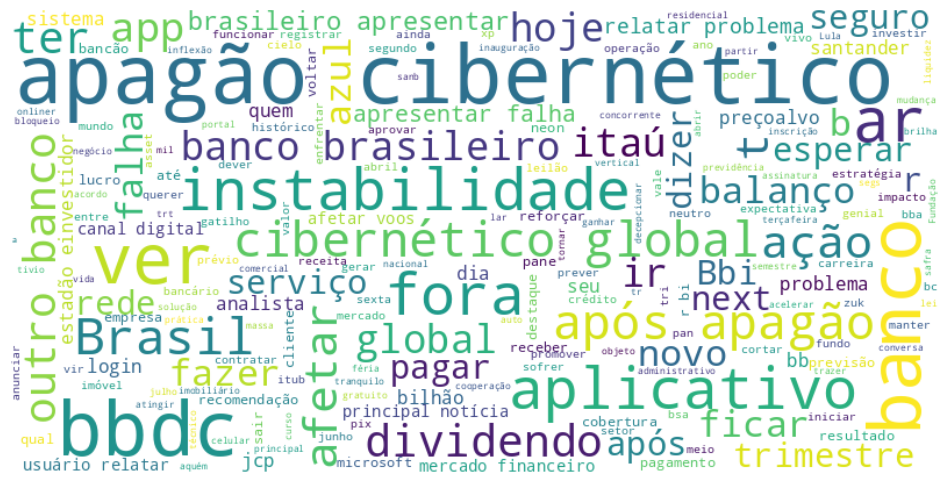

In [ ]:
# Exibir a nuvem de palavras
plt.figure(figsize=(12, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()